In [ ]:
googlecolab = True

if googlecolab:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
    !pip install Pillow==4.1.1

  ERROR: HTTP error 403 while getting http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
  ERROR: Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl because of error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
ERROR: Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl for URL http://download.pytorch.org/whl/cu101/torch-0.4.1-cp36-cp36m-linux_x86_64.whl


In [ ]:
!pip install torchsummary


In [ ]:
import numpy as np
import torch
import PIL
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os

# Paths

In [ ]:
labels = pd.read_csv('/content/drive/My Drive/Cactus/train.csv')
sub = pd.read_csv('/content/drive/My Drive/Cactus/sample_submission.csv')
train_path = '/content/drive/My Drive/Cactus/train/'
test_path = '/content/drive/My Drive/Cactus/test/'


In [ ]:
print('Num train samples:{0}'.format(len(os.listdir(train_path))))
print('Num test samples:{0}'.format(len(os.listdir(test_path))))

OSError: ignored

In [ ]:
labels.head() # show head of dataset

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [ ]:
labels['has_cactus'].value_counts() # to know proportions of cactus

1    13136
0     4364
Name: has_cactus, dtype: int64

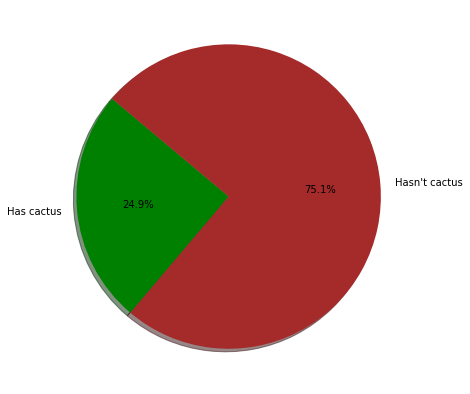

In [ ]:
lab = 'Has cactus','Hasn\'t cactus'
colors=['green','brown']

plt.figure(figsize=(7,7))
plt.pie(labels.groupby('has_cactus').size(), labels=lab,
        labeldistance=1.1, autopct='%1.1f%%',
        colors=colors,shadow=True, startangle=140)
plt.show()

## Has cactus

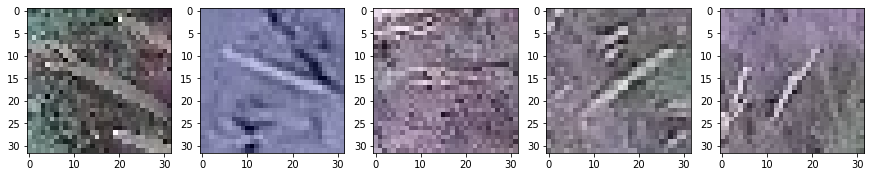

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(15,3))

for i, idx in enumerate(labels[labels['has_cactus']==1]['id'][-5:]):
  path = os.path.join(train_path,idx)
  ax[i].imshow(cv2.imread(path)) # [...,[2,1,0]]

## Has no cactus

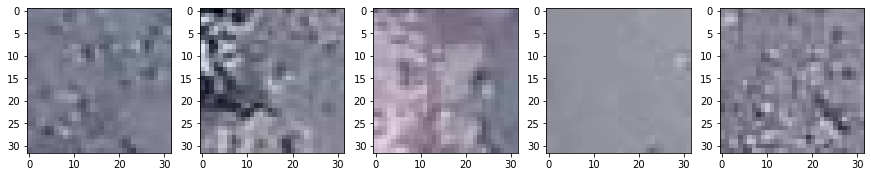

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(15,3))

for i, idx in enumerate(labels[labels['has_cactus']==0]['id'][-5:]):
  path = os.path.join(train_path,idx)
  ax[i].imshow(cv2.imread(path)) # [...,[2,1,0]]

# Deep Learning part

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

In [ ]:
# Hyper parameters
num_epochs = 25
num_classes = 2
batch_size = 128
learning_rate = 0.002

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# data splitting
train, val = train_test_split(labels, stratify=labels.has_cactus, test_size=0.1)
train.shape, val.shape

((15750, 2), (1750, 2))

In [ ]:
train['has_cactus'].value_counts()

1    11822
0     3928
Name: has_cactus, dtype: int64

In [ ]:
val['has_cactus'].value_counts()


1    1314
0     436
Name: has_cactus, dtype: int64

## Custom Generator

In [ ]:
# NOTE: class is inherited from Dataset
class MyDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name)
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
# Image preprocessing
trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(32, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_valid = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(32, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

# Data generators
dataset_train = MyDataset(df_data=train, data_dir=train_path, transform=trans_train)
dataset_valid = MyDataset(df_data=val, data_dir=train_path, transform=trans_valid)

loader_train = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
loader_valid = DataLoader(dataset = dataset_valid, batch_size=batch_size//2, shuffle=False, num_workers=0)

## Model

In [ ]:
# NOTE: class is inherited from nn.Module
class SimpleCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(4)
        self.fc = nn.Linear(512 * 1 * 1, 2) # !!!
   
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.avg(x)
        #print(x.shape) # lifehack to find out the correct dimension for the Linear Layer
        x = x.view(-1, 512 * 1 * 1) # !!!
        x = self.fc(x)
        return x


In [ ]:
model = SimpleCNN().to(device)
from torchsummary import summary
summary(model, input_size=(3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 98, 98]             896
       BatchNorm2d-2           [-1, 32, 98, 98]              64
         MaxPool2d-3           [-1, 32, 49, 49]               0
            Conv2d-4           [-1, 64, 51, 51]          18,496
       BatchNorm2d-5           [-1, 64, 51, 51]             128
         MaxPool2d-6           [-1, 64, 25, 25]               0
            Conv2d-7          [-1, 128, 27, 27]          73,856
       BatchNorm2d-8          [-1, 128, 27, 27]             256
         MaxPool2d-9          [-1, 128, 13, 13]               0
           Conv2d-10          [-1, 256, 15, 15]         295,168
      BatchNorm2d-11          [-1, 256, 15, 15]             512
        MaxPool2d-12            [-1, 256, 7, 7]               0
           Conv2d-13            [-1, 512, 9, 9]       1,180,160
      BatchNorm2d-14            [-1, 51

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

NameError: ignored

In [ ]:
# Train the model
total_step = len(loader_train)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loader_train):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/25], Step [100/124], Loss: 0.0488
Epoch [2/25], Step [100/124], Loss: 0.0261
Epoch [3/25], Step [100/124], Loss: 0.0196
Epoch [4/25], Step [100/124], Loss: 0.0255
Epoch [5/25], Step [100/124], Loss: 0.0064
Epoch [6/25], Step [100/124], Loss: 0.0019
Epoch [7/25], Step [100/124], Loss: 0.0063
Epoch [8/25], Step [100/124], Loss: 0.0241
Epoch [9/25], Step [100/124], Loss: 0.0016
Epoch [10/25], Step [100/124], Loss: 0.0014
Epoch [11/25], Step [100/124], Loss: 0.0124
Epoch [12/25], Step [100/124], Loss: 0.0011
Epoch [13/25], Step [100/124], Loss: 0.0158
Epoch [14/25], Step [100/124], Loss: 0.0262
Epoch [15/25], Step [100/124], Loss: 0.0015
Epoch [16/25], Step [100/124], Loss: 0.0084
Epoch [17/25], Step [100/124], Loss: 0.0006
Epoch [18/25], Step [100/124], Loss: 0.0021
Epoch [19/25], Step [100/124], Loss: 0.0100
Epoch [20/25], Step [100/124], Loss: 0.0021
Epoch [21/25], Step [100/124], Loss: 0.0006
Epoch [22/25], Step [100/124], Loss: 0.0007
Epoch [23/25], Step [100/124], Loss: 0.00

## Trained model saving

In [ ]:
#torch.save(model.state_dict(),'checkpoint.pth' )

## Reloading the model previously saved

In [ ]:
model = SimpleCNN()
model.load_state_dict(torch.load('/content/drive/My Drive/Cactus/checkpoint.pth'))
model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (fc): Line

In [ ]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        #print("predicted :",predicted) --> predictions per batch
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print((total))
          
    print('Test Accuracy of the model on the 1750 validation images: {} %'.format(100 * correct / total))

predicted : tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
64
predicted : tensor([1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
128
predicted : tensor([1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
192
predicted : tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
256
p

# CSV Submission

In [ ]:
# generator for test data 
dataset_valid = MyDataset(df_data=sub, data_dir=test_path, transform=trans_valid)
loader_test = DataLoader(dataset = dataset_valid, batch_size=32, shuffle=False, num_workers=0)

In [ ]:
model.eval()

preds = []
preds_labels = []

cpt = 0
for batch_i, (data, target) in enumerate(loader_test):
    data, target = data.cuda(), target.cuda()
    output = model(data)
    print(cpt)
    _, predicted = torch.max(output.data, 1) # --> predicted returns weither or not a cactus is present in the image
                                              # --> _ returns the output of the corresponding neuron
    pr = output[:,1].detach().cpu().numpy()
    lab = predicted.detach().cpu().numpy()
    for i in pr:
        preds.append(i)
    for i in lab:
      preds_labels.append(i)
    cpt = cpt + 1
sub['has_cactus'] = preds
sub['predicted_label'] = preds_labels
sub.to_csv('sub.csv', index=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124


In [ ]:
sub.head()

,id,has_cactus,predicted_label
0,000940378805c44108d287872b2f04ce.jpg,8.109980,1
1,0017242f54ececa4512b4d7937d1e21e.jpg,6.645272,1
2,001ee6d8564003107853118ab87df407.jpg,-3.624967,0
3,002e175c3c1e060769475f52182583d0.jpg,-5.304526,0
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,1.605153,1


# Extras

In [ ]:
#dataset_train[0][0] ## --> image

#dataset_train[0][1] ## --> label

plt.imshow(dataset_train[0][0][0,:,:]) # --> Red channel, [2,:,:] for green channel and [2,:,:] for blue channel

KeyboardInterrupt: ignored

In [ ]:
dataset_train.__getitem__(0)[0].size() # --> beware, this is a simple tensor, no batch dimension, can't be processed by the net

torch.Size([3, 96, 96])

In [ ]:
test = dataset_train.__getitem__(100)[0].unsqueeze(0) # Adding a batch dimension to be processed by the net
test.size()

torch.Size([1, 3, 96, 96])

In [ ]:
#torch.max(model(test.to(device)),1)

_, predicted = torch.max(model(test.to(device)), 1)
print('Value of the output neuron : ', _.item() )
print('Value of the corresponding label : ',predicted.item())

Value of the output neuron :  9.462302207946777
Value of the corresponding label :  1


## Adding SoftMax to model in order to get probabilities

In [ ]:
# NOTE: class is inherited from nn.Module
class SimpleCNN_modified(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(SimpleCNN_modified, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(4)
        self.fc = nn.Linear(512 * 1 * 1, 2) # !!!
        self.f=nn.Sigmoid()
   
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.avg(x)
        #print(x.shape) # lifehack to find out the correct dimension for the Linear Layer
        x = x.view(-1, 512 * 1 * 1) # !!!
        x = self.fc(x)
        x = self.f(x)
        return x


In [ ]:
model_bis = SimpleCNN_modified()
model_bis.load_state_dict(torch.load('/content/drive/My Drive/Cactus/checkpoint.pth'))
model_bis.to(device)

SimpleCNN_modified(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (